In [329]:
import cv2
import warnings
import mediapipe as mp
import os
import absl.logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Suppress TensorFlow, MediaPipe, and protobuf logs

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # 0 = all logs, 1 = info, 2 = warning, 3 = error only
absl.logging.set_verbosity(absl.logging.ERROR)
warnings.filterwarnings("ignore")

In [330]:

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

# For webcam input:

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as holistic:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(image)
    print(results)
    break
        
cap.release()

I0000 00:00:1762711801.318429   45953 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1762711801.319922   73054 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.7-0ubuntu0.24.04.2), renderer: AMD Radeon Graphics (radeonsi, renoir, ACO, DRM 3.61, 6.14.0-35-generic)
W0000 00:00:1762711801.356782   73041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762711801.379737   73044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762711801.381084   73044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762711801.381187   73045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. D

<class 'mediapipe.python.solution_base.SolutionOutputs'>


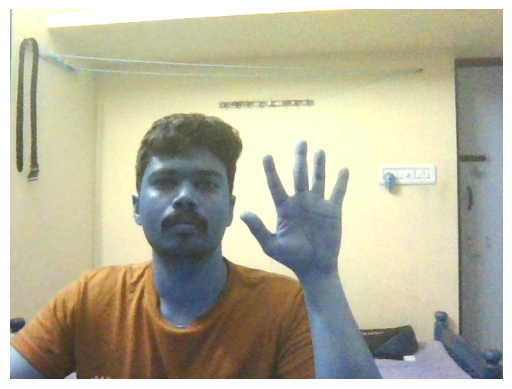

In [331]:

#image = cv2.imread(image)

image = cv2.convertScaleAbs(image, alpha=1.2, beta=25)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()



# Face landmarks plot 

In [332]:

face = pd.DataFrame(columns=['x', 'y', 'z'])

if results.face_landmarks is not None:
    for i, point in enumerate(results.face_landmarks.landmark):
        face.loc[i] = [point.x, point.y, point.z]

    face['y'] = -face['y']


<Axes: xlabel='x', ylabel='y'>

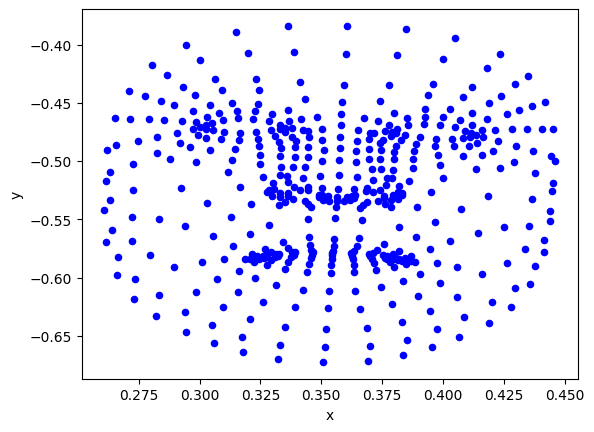

In [333]:
face.plot(x='x',y='y',kind='scatter',color='blue')

In [334]:
# Left hand landmarks

left_hand = pd.DataFrame(columns=['x', 'y', 'z'])

if results.left_hand_landmarks is not None:
    for i, point in enumerate(results.left_hand_landmarks.landmark):
        left_hand.loc[i] = [point.x, point.y, point.z]

    left_hand['y'] = -left_hand['y']

<Axes: xlabel='x', ylabel='y'>

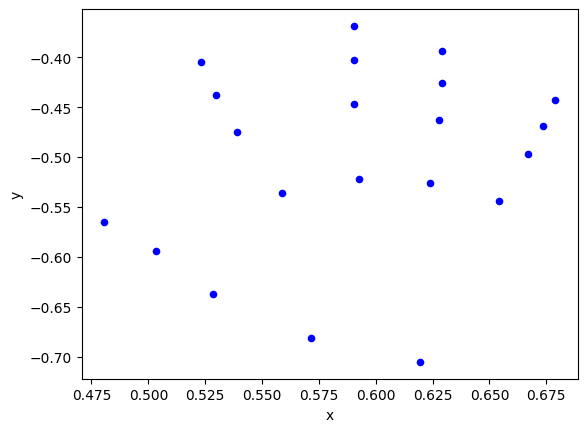

In [335]:
left_hand.plot(x='x',y='y',kind='scatter',color='blue')

In [336]:
#right hand landmarks


right_hand = pd.DataFrame(columns=['x', 'y', 'z'])

if results.right_hand_landmarks is not None:
    for i, point in enumerate(results.right_hand_landmarks.landmark):
        right_hand.loc[i] = [point.x, point.y, point.z]

    right_hand['y'] = -right_hand['y']

<Axes: xlabel='x', ylabel='y'>

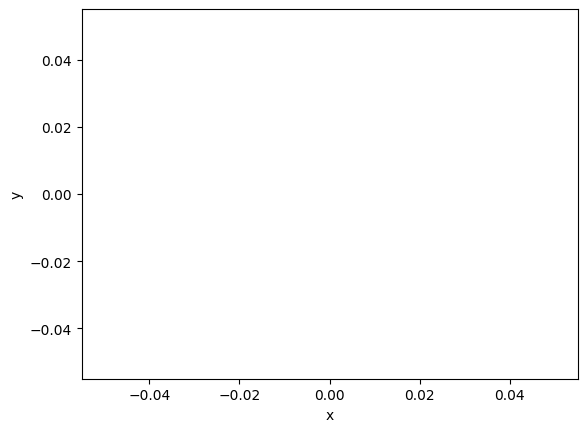

In [337]:
right_hand.plot(x='x',y='y',kind='scatter',color='blue')

In [338]:
#pose landmarks

pose = pd.DataFrame(columns=['x', 'y', 'z'])

if results.pose_landmarks is not None:
    for i, point in enumerate(results.pose_landmarks.landmark):
        pose.loc[i] = [point.x, point.y, point.z]

    pose['y'] = -pose['y']

<Axes: xlabel='x', ylabel='y'>

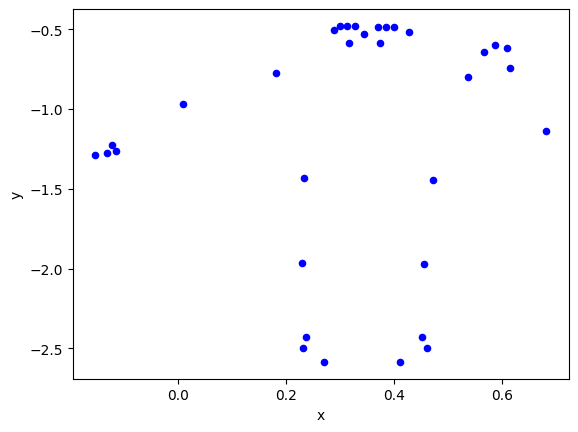

In [339]:
pose.plot(x='x',y='y',kind='scatter',color='blue')

In [340]:
import pandas as pd
import pyarrow

train = pd.read_csv("../asl-signs/train.csv")
pq_file = "../asl-signs/train_landmark_files/16069/10042041.parquet"
xyz = pd.read_parquet(pq_file)

In [341]:
train.query('sequence_id==10042041')

,path,participant_id,sequence_id,sign
101,train_landmark_files/16069/10042041.parquet,16069,10042041,green


In [342]:
xyz['frame'].value_counts()

83     543
136    543
160    543
159    543
158    543
      ... 
115    543
114    543
113    543
112    543
187    543
Name: frame, Length: 105, dtype: int64

In [343]:
##%%
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [344]:
xyz_np = load_relevant_data_subset(pq_file)
xyz_np.shape

(105, 543, 3)

# Make the data taken from cam using mediapipe to the shape we need 

In [345]:
def create_frame_landmark_df(results,frame):
    xyz_skel = (
    xyz[['type', 'landmark_index']]
    .drop_duplicates()
    .reset_index(drop=True)
    .copy()
)

    # initialize empty dataframes
    face = pd.DataFrame()
    pose = pd.DataFrame()
    left_hand = pd.DataFrame()
    right_hand = pd.DataFrame()
    
    # ---- FACE ----
    if results.face_landmarks:
        for i, point in enumerate(results.face_landmarks.landmark):
            face.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    # ---- POSE ----
    if results.pose_landmarks:
        for i, point in enumerate(results.pose_landmarks.landmark):
            pose.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    # ---- LEFT HAND ----
    if results.left_hand_landmarks:
        for i, point in enumerate(results.left_hand_landmarks.landmark):
            left_hand.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    # ---- RIGHT HAND ----
    if results.right_hand_landmarks:
        for i, point in enumerate(results.right_hand_landmarks.landmark):
            right_hand.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    
    face = (
    face.reset_index()
    .rename(columns={'index': 'landmark_index'})
    .assign(type='face')
    )

    pose = (
        pose.reset_index()
        .rename(columns={'index': 'landmark_index'})
        .assign(type='pose')
    )

    lefthand = (
        left_hand.reset_index()
        .rename(columns={'index': 'landmark_index'})
        .assign(type='left_hand')
    )
    
    righthand = (
        right_hand.reset_index()
        .rename(columns={'index': 'landmark_index'})
        .assign(type='right_hand')
    )
    landmarks = pd.concat([face,pose,lefthand,righthand]).reset_index(drop=True)
    landmarks = xyz_skel = xyz_skel.merge(landmarks, on=['type', 'landmark_index'], how='left')
    landmarks = landmarks.assign(frame=frame)

    return landmarks

    



In [346]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
landmarks = create_frame_landmark_df(results,0)
landmarks

,type,landmark_index,x,y,z,frame
0,face,0,0.355274,0.567238,-0.027776,0
1,face,1,0.356835,0.523731,-0.042529,0
2,face,2,0.356106,0.539460,-0.024997,0
3,face,3,0.350944,0.490511,-0.028207,0
4,face,4,0.357221,0.512240,-0.044040,0
...,...,...,...,...,...,...
538,right_hand,16,NaN,NaN,NaN,0
539,right_hand,17,NaN,NaN,NaN,0
540,right_hand,18,NaN,NaN,NaN,0
541,right_hand,19,NaN,NaN,NaN,0


In [348]:
train['sign'].value_counts()

listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: sign, Length: 250, dtype: int64